In [23]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))


def load_filtered_data_from_h5(h5_file_path):
    """
    Loads the 'filtered_data' group from an HDF5 file into a Pandas DataFrame.
    """
    with h5py.File(h5_file_path, "r") as hf:
        # Access the group where the DataFrame columns were saved
        grp = hf["filtered_data"]
        
        # Each dataset in 'grp' is a column; read them into a dict of numpy arrays
        data_dict = {}
        for col_name in grp.keys():
            # Read dataset
            col_data = grp[col_name][:]
            
            # If it's a string dataset, h5py might already give you Python strings,
            # but just to be safe, handle bytes if encountered
            if col_data.dtype.kind in ["S", "O"] or isinstance(col_data.flatten()[0], bytes):
                col_data = [elem.decode("utf-8") if isinstance(elem, bytes) else elem 
                            for elem in col_data]
            
            data_dict[col_name] = col_data
        
    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data_dict)
    return df

# def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None, xlim=None):
#     """
#     Plots cluster timeline on a provided Axes object (ax),
#     aligned with time_index if given, and colored by behavior labels if provided.
    
#     Parameters:
#         ax: Matplotlib Axes object.
#         df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
#         time_index: (Optional) Time index to map frames to timestamps.
#         behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
#         xlim: (Optional) Tuple specifying x-axis limits (e.g., (0, 100)).
#     """
#     unique_paths = df['Prediction_path'].unique()
#     cmap = plt.cm.tab10
#     cluster_colors = {}

#     if behavior_labels:
#         unique_behaviors = set(behavior_labels.values())
#         behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
#         for cluster, behavior in behavior_labels.items():
#             cluster_colors[cluster] = behavior_colors[behavior]

#     for path in unique_paths:
#         path_data = df[df['Prediction_path'] == path]
#         frames = path_data['frame'].values if 'frame' in path_data.columns else np.arange(len(path_data))
#         clusters = path_data['Cluster'].values
        
#         if time_index is not None:
#             frames = frames.astype(int)
#             valid_mask = (frames >= 0) & (frames < len(time_index))
#             frames_valid = frames[valid_mask]
#             clusters_valid = clusters[valid_mask]
#             plot_x = time_index[frames_valid]
#         else:
#             plot_x = frames

#         if behavior_labels:
#             colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
#         else:
#             norm = plt.Normalize(vmin=min(clusters), vmax=max(clusters))
#             colors = plt.cm.tab10(norm(clusters))

#         ax.scatter(plot_x, np.zeros_like(plot_x), c=colors, marker='|', s=200, label=path)

#     if xlim:
#         ax.set_xlim(xlim)

def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None):
    """
    Plots cluster timeline on a provided Axes object (ax),
    aligned with time_index if given, and colored by behavior labels if provided.
    
    Parameters:
        ax: Matplotlib Axes object.
        df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
        time_index: (Optional) Time index to map frames to timestamps.
        behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
    """
    unique_paths = df['Prediction_path'].unique()

    # Default colormap
    cmap = plt.cm.tab10
    cluster_colors = {}
    
    # Prepare behavior-specific colors if labels are provided
    if behavior_labels:
        unique_behaviors = set(behavior_labels.values())
        behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
        for cluster, behavior in behavior_labels.items():
            cluster_colors[cluster] = behavior_colors[behavior]

    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]
        
        # Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Get clusters
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # Convert string clusters to numeric if needed
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = np.unique(clusters)
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Map frames -> timestamps if time_index is provided
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            frames_valid = frames[valid_mask]
            clusters_valid = clusters[valid_mask]
            plot_x = time_index[frames_valid]  # Actual timestamps
        else:
            frames_valid = frames
            clusters_valid = clusters
            plot_x = frames_valid
        
        # Map clusters to colors
        if behavior_labels:
            colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
        else:
            unique_clusters = np.unique(clusters_valid)
            norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
            colors = plt.cm.tab10(norm(clusters_valid))
        
        # Plot on the provided Axes
        ax.scatter(plot_x, np.zeros_like(plot_x), 
                   c=colors, marker='|', s=200, label=path)
    
    # Cosmetic fixes
    ax.set_title("Cluster Timeline by Behavior")
    # ax.set_yticks([])
    if behavior_labels:
        ax.legend(handles=[plt.Line2D([0], [0], color=color, marker='|', 
                                       markersize=10, label=behavior, linestyle='None') 
                           for behavior, color in behavior_colors.items()],
                  loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust as needed

# def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None):
#     """
#     Plots cluster timeline on a provided Axes object (ax),
#     aligned with time_index if given, and colored by behavior labels if provided.
    
#     Parameters:
#         ax: Matplotlib Axes object.
#         df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
#         time_index: (Optional) Time index to map frames to timestamps.
#         behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
#     """
#     unique_paths = df['Prediction_path'].unique()

#     # Default colormap
#     cmap = plt.cm.tab10
#     cluster_colors = {}
    
#     # Prepare behavior-specific colors if labels are provided
#     if behavior_labels:
#         unique_behaviors = set(behavior_labels.values())
#         behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
#         for cluster, behavior in behavior_labels.items():
#             cluster_colors[cluster] = behavior_colors[behavior]

#     for path in unique_paths:
#         path_data = df[df['Prediction_path'] == path]
        
#         # Identify frames
#         if 'frame' in path_data.columns:
#             frames = path_data['frame'].values
#         elif 'n_frames' in path_data.columns:
#             frames = path_data['n_frames'].values
#         else:
#             frames = np.arange(len(path_data))
        
#         # Get clusters
#         if 'Cluster' not in path_data.columns:
#             print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
#             continue
#         clusters = path_data['Cluster'].values
        
#         # Convert string clusters to numeric if needed
#         if not np.issubdtype(clusters.dtype, np.number):
#             unique_str_clusters = np.unique(clusters)
#             cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
#             clusters_numeric = [cluster_idx_map[c] for c in clusters]
#             clusters = np.array(clusters_numeric)
        
#         # Map frames -> timestamps if time_index is provided
#         if time_index is not None:
#             frames = frames.astype(int)
#             valid_mask = (frames >= 0) & (frames < len(time_index))
#             frames_valid = frames[valid_mask]
#             clusters_valid = clusters[valid_mask]
#             plot_x = time_index[frames_valid]  # Actual timestamps
#         else:
#             frames_valid = frames
#             clusters_valid = clusters
#             plot_x = frames_valid
        
#         # Map clusters to colors
#         if behavior_labels:
#             colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
#         else:
#             unique_clusters = np.unique(clusters_valid)
#             norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
#             colors = plt.cm.tab10(norm(clusters_valid))
        
#         # Plot on the provided Axes
#         ax.scatter(plot_x, clusters_valid, 
#                    c=colors, marker='|', s=200, label=path, alpha=0.8)
    
#     # Cosmetic fixes to match isolated behaviors
#     ax.set_title("Cluster Timeline by Behavior", pad=10)
#     ax.set_yticks([])  # Remove y-axis ticks
#     ax.set_ylabel("")  # Remove y-axis label
#     ax.spines['left'].set_visible(False)  # Hide left spine
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.grid(False)  # Remove grid lines

#     # Optional legend for behaviors
#     if behavior_labels:
#         ax.legend(
#             handles=[plt.Line2D([0], [0], color=color, marker='|', 
#                                 markersize=10, label=behavior, linestyle='None') 
#                      for behavior, color in behavior_colors.items()],
#             loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Adjust as needed

def plot_behavior_clusters(ax, df, behavior_name, behavior_labels, time_index=None, cluster_column='Cluster', frame_column='frame'):
    """
    Plots all clusters corresponding to a specific behavior on a given Axes object.
    
    Parameters:
        ax: Matplotlib Axes object.
        df: DataFrame containing cluster and frame information.
        behavior_name: The behavior to plot (e.g., 'Grooming').
        behavior_labels: Dictionary mapping clusters to behavior names.
        time_index: (Optional) Time index for mapping frames to timestamps.
        cluster_column: Name of the column containing cluster IDs.
        frame_column: Name of the column containing frame indices.
    """
    # Identify clusters corresponding to the behavior
    clusters = [cluster for cluster, behavior in behavior_labels.items() if behavior == behavior_name]
    
    # Filter DataFrame for the selected clusters
    behavior_data = df[df[cluster_column].isin(clusters)]
    
    if time_index is not None and frame_column in behavior_data.columns:
        # Map frames to actual time
        frames = behavior_data[frame_column].astype(int)
        valid_mask = (frames >= 0) & (frames < len(time_index))
        plot_x = time_index[frames[valid_mask]]
    else:
        plot_x = behavior_data[frame_column].values if frame_column in behavior_data.columns else np.arange(len(behavior_data))
    
    # Plot the behavior
    ax.vlines(plot_x, ymin=0, ymax=1, color='black', label=behavior_name)
    ax.set_title(f"Behavior: {behavior_name}")
    ax.set_ylabel("Activity")
    ax.set_yticks([])
    ax.legend(loc='upper right')

In [26]:
df_merged_with_dF_F

,com_x,com_y,com_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,dF_F_roi77,dF_F_roi78,dF_F_roi79,dF_F_roi80,dF_F_roi81,dF_F_roi82,dF_F_roi83,dF_F_roi84,dF_F_roi85,dF_F_roi86
timestamp_ms_mini,,,,,,,,,,,,,,,,,,,,,
-28,41.706841,527.997575,10.797444,13.583969,533.438843,19.441160,35.926529,553.407898,19.521400,10.872994,...,5.450978,0.820760,1.868120,0.456811,1.014832,1.502012,2.116763,4.093864,-0.077933,0.503355
76,41.555597,528.230113,9.798887,12.700958,533.384277,18.862123,36.603622,552.807739,18.320738,11.129997,...,4.451628,0.938705,1.827905,0.178854,1.074192,1.681203,2.263206,3.354450,-0.027647,0.689176
173,41.311852,528.230113,9.676444,12.057464,535.820007,19.843277,36.404842,554.592407,18.491831,9.565206,...,3.323933,0.936644,1.776339,0.431037,1.219960,1.304163,1.663213,1.884310,0.063689,0.471626
284,41.311852,528.230113,9.676444,13.367846,534.604065,21.027853,38.033424,552.758179,18.725048,11.425719,...,3.754166,1.546126,2.289237,0.665953,1.346383,1.647476,2.277503,1.947350,0.081327,0.852772
383,41.070991,528.230113,9.798887,13.515869,534.713684,22.168043,39.517872,551.007874,19.403019,11.013714,...,3.008973,1.027965,1.807050,0.314316,1.866527,1.861826,2.073067,2.633667,0.038555,0.634334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895154,561.426280,491.163603,16.114240,571.295227,516.943359,17.747700,587.236877,493.928833,21.752941,593.425476,...,2.471127,-0.212385,0.395668,0.431881,0.664789,0.294658,0.583652,-0.117043,1.580501,0.633466
895262,565.447285,492.621053,16.114240,578.877075,522.396729,18.414005,593.763428,497.212463,21.706463,603.196899,...,0.593495,0.637050,0.732832,0.356040,0.354433,0.338199,0.067821,-0.772679,1.327936,0.584110
895354,571.293731,496.557728,16.212091,582.323486,525.675598,20.198135,600.818298,503.946777,22.326832,604.418945,...,2.264685,1.084643,0.529707,0.489709,0.657618,0.661684,0.214412,-0.757433,1.044665,0.846073


In [34]:
# -------------------------------------------------------------------
# 3) Example usage with filtered_df (loaded from HDF5)
#    You already have a function for that, e.g. load_filtered_data_from_h5
# -------------------------------------------------------------------
aligned_dappy_path = "/home/lq53/mir_repos/dappy_24_nov/byws_version/250109_opti/60_p/aligned_mir_walalala_filtered_data.h5"

filtered_df = load_filtered_data_from_h5(aligned_dappy_path)

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]

# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

# Define behavior labels for clusters
# behavior_labels = {
#     1: 'Grooming', 4: 'Grooming', 7: 'Grooming', 23: 'Grooming',
#     2: 'Sniffing', 5: 'Sniffing', 10: 'Sniffing', 30: 'Walking'
# }
behavior_labels = {
    1: 'sniffing', 2: 'sniffing', 29: 'sniffing', 30: 'sniffing', 52: 'sniffing',
    3: 'sniffing and walking', 4: 'sniffing and walking', 5: 'sniffing and walking',
    6: 'sniffing and walking', 7: 'sniffing and walking', 8: 'sniffing and walking',
    9: 'sniffing and walking', 11: 'sniffing and walking', 13: 'sniffing and walking',
    14: 'sniffing and walking', 15: 'sniffing and walking', 17: 'sniffing and walking',
    18: 'sniffing and walking', 19: 'sniffing and walking', 20: 'sniffing and walking',
    21: 'sniffing and walking',
    10: 'static', 69: 'static', 103: 'static', 127: 'static', 121: 'static',
    104: 'grooming and walking',
    72: 'grooming', 79: 'grooming', 80: 'grooming', 81: 'grooming', 92: 'grooming',
    100: 'grooming', 111: 'grooming', 113: 'grooming',
    82: 'edge peeking', 83: 'edge peeking',
    89: 'rearing and walking'
}

# Add all remaining indices as 'sniffing and walking'
all_indices = set(range(1, 130))  # Assuming the range of interest is from 1 to 129
bad_indices = {16, 27, 39, 42, 60}
defined_indices = set(behavior_labels.keys())

# Find the remaining indices for 'sniffing and walking'
remaining_indices = all_indices - bad_indices - defined_indices

# Add them to the dictionary
for idx in remaining_indices:
    behavior_labels[idx] = 'sniffing and walking'


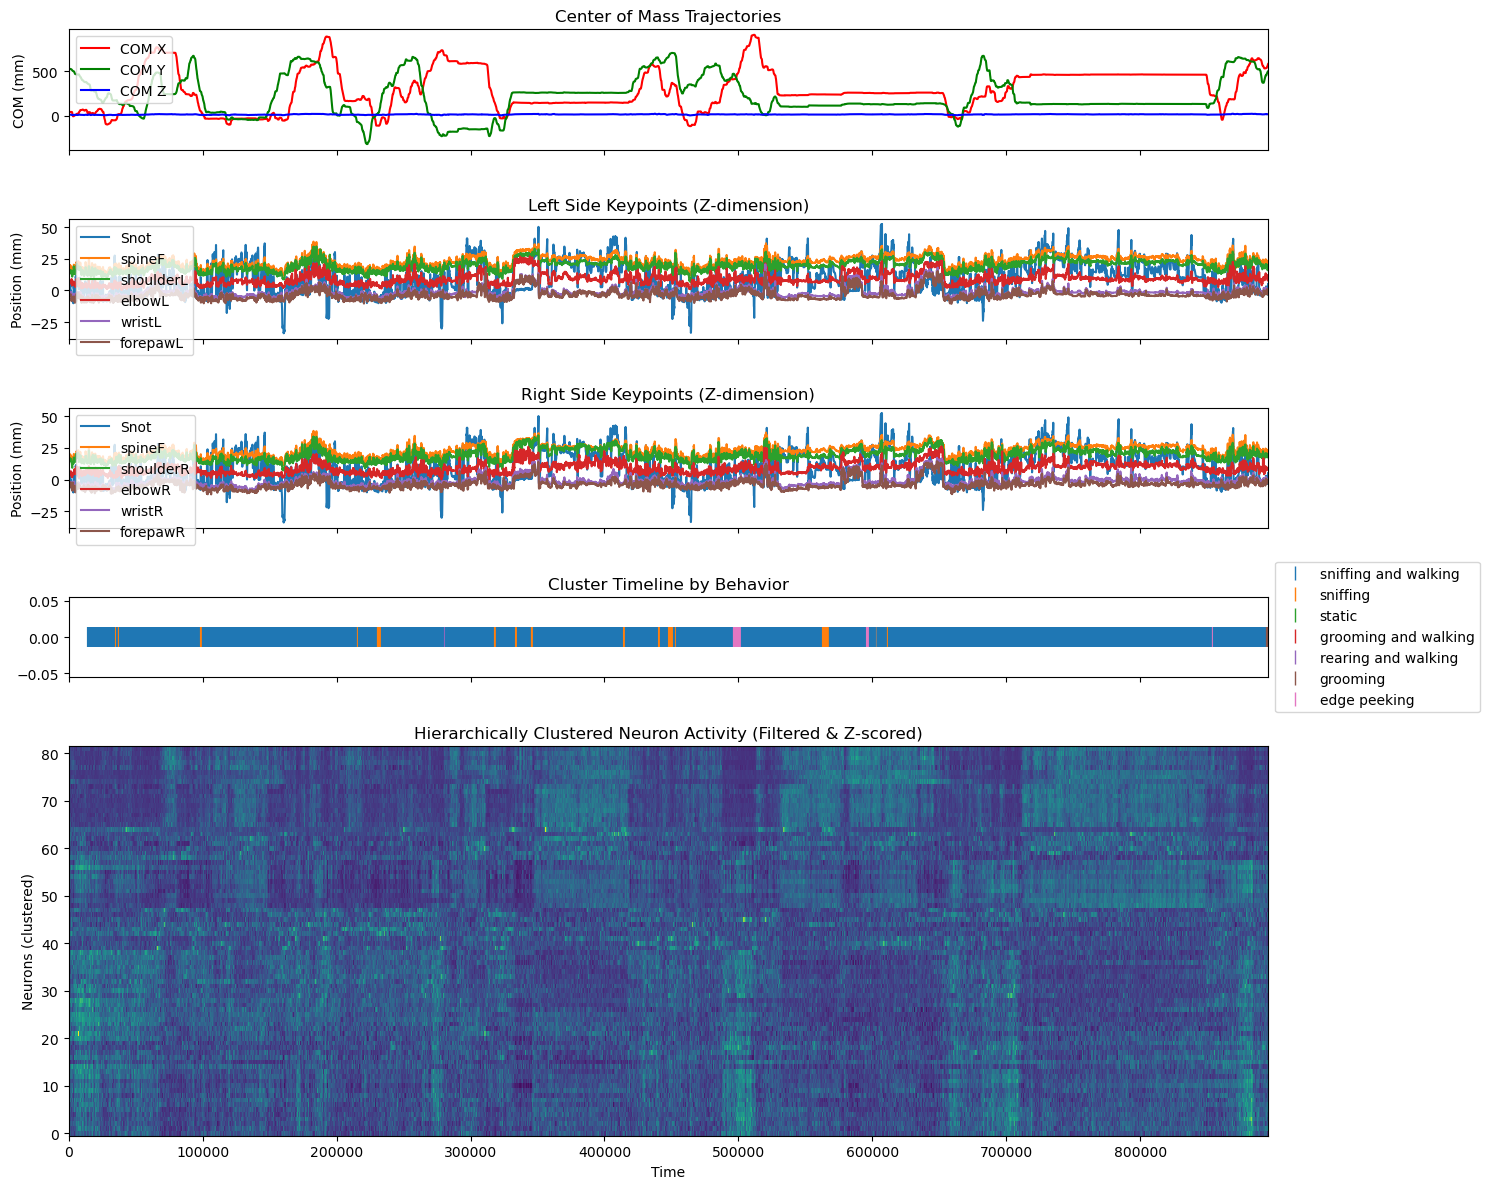

In [31]:
def main_plot_function(df_merged_with_dF_F, filtered_df, neuron_activity_normalized=None, filtered_neuron_columns=None):
    """
    Example main plotting function that:
      1) Plots COM (row 0)
      2) Plots left keypoints (row 1)
      3) Plots right keypoints (row 2)
      4) Plots the cluster timeline (row 3)
      5) Plots the Ca heatmap (rows 4-5)
    """
    df_new = df_merged_with_dF_F
    
    # Example location indices and labels
    location_indices_left = [3, 4, 12, 11, 10, 9]
    location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

    location_indices_right = [3, 4, 16, 15, 14, 13]
    location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

    # Assume time is the index
    time = df_new.index
    
    # --- Figure & GridSpec ---
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(nrows=6, ncols=1, height_ratios=[1.5, 1.5, 1.5, 1, 1, 3])
    # That gives us:
    #  row 0 => ax1 for COM
    #  row 1 => ax2 for Left Keypoints
    #  row 2 => ax3 for Right Keypoints
    #  row 3 => ax4 for cluster timeline
    #  row 4-5 => ax5 for Ca heatmap

    ###########################################
    # Top Plot (row 0): COM trajectories
    ###########################################
    ax1 = fig.add_subplot(gs[0, 0])
    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax1.plot(time, df_new['com_x'], color='red', label='COM X')
        ax1.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax1.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax1.set_ylabel('COM (mm)')
        ax1.set_title('Center of Mass Trajectories')
        ax1.legend(loc='upper left')
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    ax1.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Second Plot (row 1): Left Side Keypoints (Z-dim)
    ###########################################
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_title('Left Side Keypoints (Z-dimension)')
    for idx in location_indices_left:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax2.plot(time, df_new[z_col], label=location_labels_left[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax2.set_ylabel('Position (mm)')
    ax2.legend(loc='upper left')
    ax2.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Third Plot (row 2): Right Side Keypoints (Z-dim)
    ###########################################
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.set_title('Right Side Keypoints (Z-dimension)')
    for idx in location_indices_right:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax3.plot(time, df_new[z_col], label=location_labels_right[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax3.set_ylabel('Position (mm)')
    ax3.legend(loc='upper left')
    ax3.tick_params(labelbottom=False)  # Remove x-axis labels

    ###########################################
    # Fourth Plot (row 3): Cluster Timeline
    ###########################################
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    # Instead of calling a separate figure function, we use our timeline-on-axes function:
    plot_cluster_timeline_on_axes(ax4, filtered_df, time_index=df_new.index, behavior_labels=behavior_labels)
    # Remove x labels if you want the final plot to handle them:
    ax4.tick_params(labelbottom=False)

    ###########################################
    # Fifth Plot (rows 4-5): Ca heatmap
    ###########################################
    ax5 = fig.add_subplot(gs[4:6, 0], sharex=ax1)
    
    # Check if we have the neuron activity data
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)  # Leaves from dendrogram
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

        # Time axis
        time_values = time  # or np.arange(neuron_activity_ordered.shape[1])

        # Plot heatmap with pcolormesh
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax5.pcolormesh(
            time_values, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax5.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax5.set_ylabel('Neurons (clustered)')
        ax5.set_xlabel('Time')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax5.text(0.5, 0.5, 'No neuron activity data available.',
                 transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('No Neuron Activity Plot')

    plt.tight_layout()
    plt.show()
# Example call:
main_plot_function(df_merged_with_dF_F, filtered_df,
                   neuron_activity_normalized=neuron_activity_normalized,
                   filtered_neuron_columns=filtered_neuron_columns)


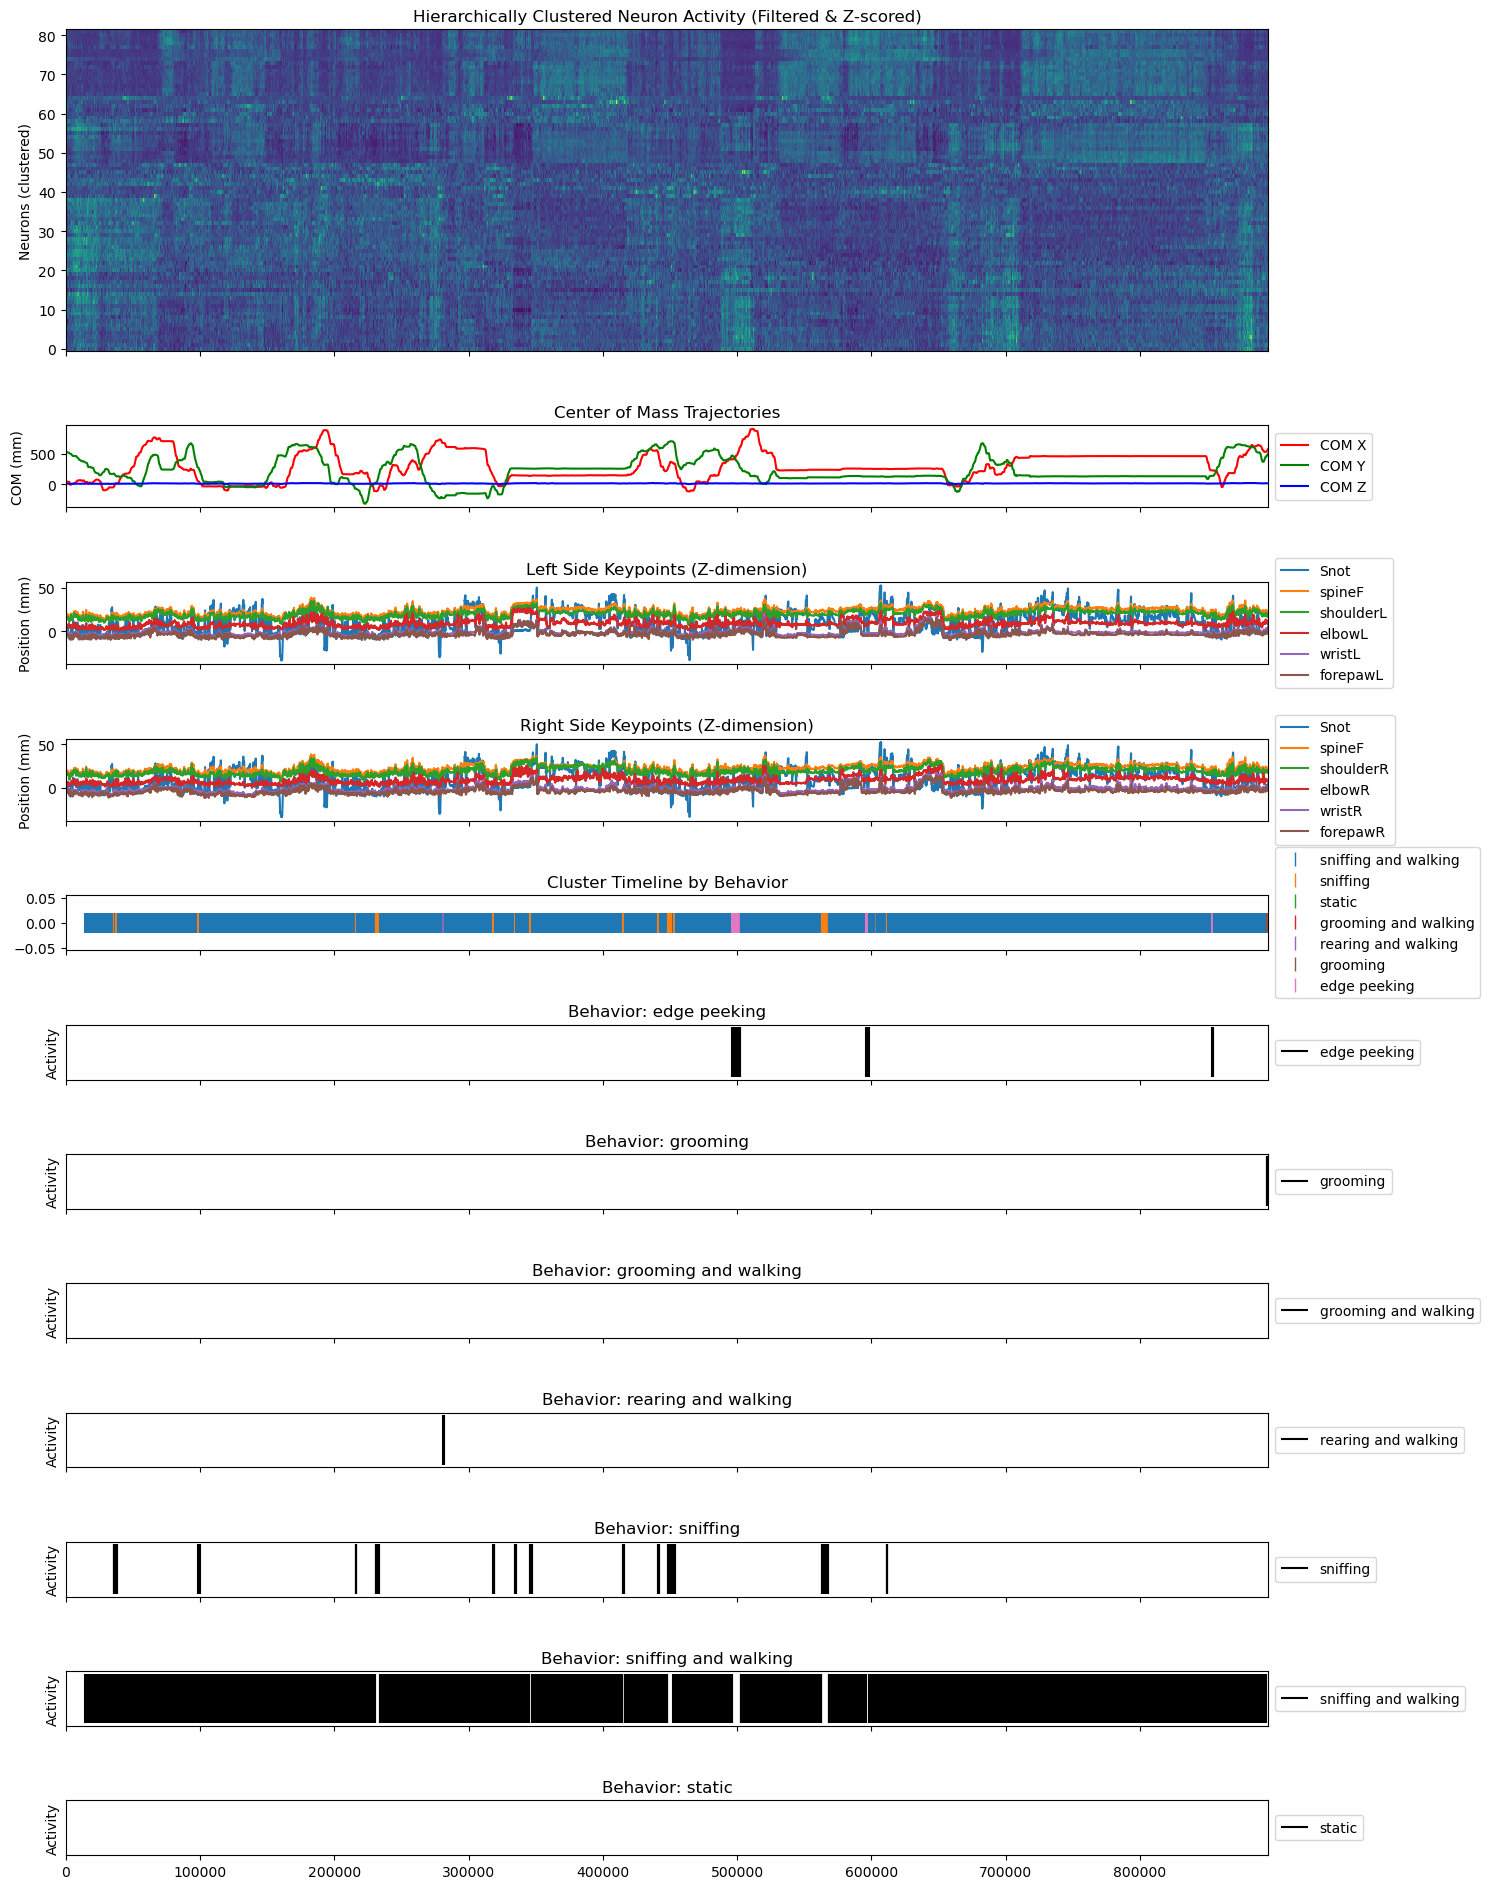

In [32]:
def main_plot_function(df_merged_with_dF_F, filtered_df, neuron_activity_normalized=None, filtered_neuron_columns=None):
    """
    Example main plotting function that:
      1) Plots the Ca heatmap (rows 0-1)
      2) Plots COM (row 2)
      3) Plots left keypoints (row 3)
      4) Plots right keypoints (row 4)
      5) Plots the cluster timeline (row 5)
      6) Plots individual behavior timelines (rows 6+)
    """
    df_new = df_merged_with_dF_F

    # Example location indices and labels
    location_indices_left = [3, 4, 12, 11, 10, 9]
    location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

    location_indices_right = [3, 4, 16, 15, 14, 13]
    location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

    # Assume time is the index
    time = df_new.index

    # --- Figure & GridSpec ---
    unique_behaviors = sorted(set(behavior_labels.values()))
    num_behaviors = len(unique_behaviors)
    fig = plt.figure(figsize=(15, 12 + num_behaviors))  # Adjust height based on behaviors
    gs = fig.add_gridspec(nrows=6 + num_behaviors, ncols=1, height_ratios=[3, 1.5, 1.5, 1.5, 1.5, 1] + [1] * num_behaviors)

    ###########################################
    # Top Plot (rows 0-1): Ca heatmap
    ###########################################
    ax1 = fig.add_subplot(gs[0:2, 0])
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)  # Leaves from dendrogram
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

        # Plot heatmap with pcolormesh
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax1.pcolormesh(
            time, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax1.set_ylabel('Neurons (clustered)')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax1.text(0.5, 0.5, 'No neuron activity data available.',
                 transform=ax1.transAxes, ha='center', va='center')
        ax1.set_title('No Neuron Activity Plot')
    ax1.tick_params(labelbottom=False)

    ###########################################
    # Second Plot (row 2): COM trajectories
    ###########################################
    ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax2.plot(time, df_new['com_x'], color='red', label='COM X')
        ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax2.set_ylabel('COM (mm)')
        ax2.set_title('Center of Mass Trajectories')
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    ax2.tick_params(labelbottom=False)

    ###########################################
    # Third Plot (row 3): Left Side Keypoints (Z-dim)
    ###########################################
    ax3 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax3.set_title('Left Side Keypoints (Z-dimension)')
    for idx in location_indices_left:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax3.plot(time, df_new[z_col], label=location_labels_left[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax3.set_ylabel('Position (mm)')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    ax3.tick_params(labelbottom=False)

    ###########################################
    # Fourth Plot (row 4): Right Side Keypoints (Z-dim)
    ###########################################
    ax4 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax4.set_title('Right Side Keypoints (Z-dimension)')
    for idx in location_indices_right:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax4.plot(time, df_new[z_col], label=location_labels_right[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax4.set_ylabel('Position (mm)')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    ax4.tick_params(labelbottom=False)

    ###########################################
    # Fifth Plot (row 5): Cluster Timeline
    ###########################################
    ax5 = fig.add_subplot(gs[5, 0], sharex=ax1)
    plot_cluster_timeline_on_axes(
        ax5, 
        filtered_df, 
        time_index=df_new.index, 
        behavior_labels=behavior_labels, 
        # xlim=ax1.get_xlim()  # Match x-axis limits with ax1
    )
    ax5.tick_params(labelbottom=False)
    # ax5.set_yticks([])
    # ax5.set_ylabel("") 
    # ax5.set_xticks([])
    # ax5.set_xlabel("")

    ###########################################
    # Behavior Plots (rows 6+): Individual timelines
    ###########################################
    for i, behavior in enumerate(unique_behaviors):
        ax = fig.add_subplot(gs[6 + i, 0], sharex=ax1)
        plot_behavior_clusters(ax, filtered_df, behavior_name=behavior, behavior_labels=behavior_labels, time_index=time)
        ax.set_title(f'Behavior: {behavior}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
        if i < num_behaviors - 1:
            ax.tick_params(labelbottom=False)  # Remove x-axis labels except for the last plot

    plt.tight_layout()
    plt.show()


# Example call:
main_plot_function(df_merged_with_dF_F, filtered_df,
                   neuron_activity_normalized=neuron_activity_normalized,
                   filtered_neuron_columns=filtered_neuron_columns)
